In [1]:
import pandas as pd
import numpy as np
import itertools as it

import pickle as pcl

import math

%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

from collections import Counter

from mpl_toolkits.mplot3d import Axes3D

In [2]:
import hightolowz

from protocluster_completeness_purity import cluster_stats

In [3]:
L = 480.279

## Data

In [4]:
# gals = pd.read_csv('data/z0_virial_s9.csv', skiprows=59, skipfooter=1, engine='python')

halos_z2p07 = pd.read_csv('data/halos/protocluster_halos_r200_z2p07.csv', 
                          skiprows=86, skipfooter=1, engine='python')

KeyboardInterrupt: 

In [5]:
gals_z9p72_sfr = pd.read_csv('data/r200/henriques2015a_z9p72_sfr_r200.csv', skiprows=122, skipfooter=1, engine='python')
gals_z8p93_sfr = pd.read_csv('data/r200/henriques2015a_z8p93_sfr_r200.csv', skiprows=122, skipfooter=1, engine='python')
gals_z8p22_sfr = pd.read_csv('data/r200/henriques2015a_z8p22_sfr_r200.csv', skiprows=122, skipfooter=1, engine='python')
gals_z6p97_sfr = pd.read_csv('data/r200/henriques2015a_z6p97_sfr_r200.csv', skiprows=122, skipfooter=1, engine='python')

In [ ]:
gals_z5p92_sfr = pd.read_csv('data/r200/henriques2015a_z5p92_sfr_r200.csv', skiprows=122, skipfooter=1, engine='python')
gals_z5p03_sfr = pd.read_csv('data/r200/henriques2015a_z5p03_sfr_r200.csv', skiprows=122, skipfooter=1, engine='python')
gals_z3p95_sfr = pd.read_csv('data/r200/henriques2015a_z3p95_sfr_r200.csv', skiprows=122, skipfooter=1, engine='python')
gals_z3p10_sfr = pd.read_csv('data/r200/henriques2015a_z3p10_sfr_r200.csv', skiprows=122, skipfooter=1, engine='python')
gals_z2p07_sfr = pd.read_csv('data/r200/henriques2015a_z2p07_sfr_r200.csv', skiprows=122, skipfooter=1, engine='python')

In [ ]:
gals_z9p72_mstar = pd.read_csv('data/r200/henriques2015a_z9p72_stellarMass_r200.csv', skiprows=122, skipfooter=1, engine='python')
gals_z8p93_mstar = pd.read_csv('data/r200/henriques2015a_z8p93_stellarMass_r200.csv', skiprows=122, skipfooter=1, engine='python')
gals_z8p22_mstar = pd.read_csv('data/r200/henriques2015a_z8p22_stellarMass_r200.csv', skiprows=122, skipfooter=1, engine='python')
gals_z6p97_mstar = pd.read_csv('data/r200/henriques2015a_z6p97_stellarMass_r200.csv', skiprows=122, skipfooter=1, engine='python')

In [ ]:
gals_z5p92_mstar = pd.read_csv('data/r200/henriques2015a_z5p92_stellarMass_r200.csv', skiprows=122, skipfooter=1, engine='python')
gals_z5p03_mstar = pd.read_csv('data/r200/henriques2015a_z5p03_stellarMass_r200.csv', skiprows=122, skipfooter=1, engine='python')
gals_z3p95_mstar = pd.read_csv('data/r200/henriques2015a_z3p95_stellarMass_r200.csv', skiprows=122, skipfooter=1, engine='python')
gals_z3p10_mstar = pd.read_csv('data/r200/henriques2015a_z3p10_stellarMass_r200.csv', skiprows=122, skipfooter=1, engine='python')
gals_z2p07_mstar = pd.read_csv('data/r200/henriques2015a_z2p07_stellarMass_r200.csv', skiprows=122, skipfooter=1, engine='python')

## Shapes

methods

In [213]:
def calc_axes(coods):
    """
    Args:
        coods - normed coordinates
    """
    
    I = np.zeros((3, 3))

    I[0,0] = np.sum(coods[:,1]**2 + coods[:,2]**2)
    I[1,1] = np.sum(coods[:,0]**2 + coods[:,2]**2)
    I[2,2] = np.sum(coods[:,1]**2 + coods[:,0]**2)

    I[0,1] = I[1,0] = - np.sum(coods[:,0] * coods[:,1])
    I[1,2] = I[2,1] = - np.sum(coods[:,2] * coods[:,1])
    I[0,2] = I[2,0] = - np.sum(coods[:,2] * coods[:,0])

    e_values, e_vectors = np.linalg.eig(I)
    
#     sort_idx = np.argsort(e_values)
    
#     print e_values
#     print e_vectors
#     print sort_idx
    
#     e_values = e_values[sort_idx]
#     e_vectors = e_vectors[sort_idx,:]
    
    print e_values
    print e_vectors

    a = ((5. / (2 * len(coods))) * (e_values[1] + e_values[2] - e_values[0]))**0.5
    b = ((5. / (2 * len(coods))) * (e_values[0] + e_values[2] - e_values[1]))**0.5
    c = ((5. / (2 * len(coods))) * (e_values[0] + e_values[1] - e_values[2]))**0.5

    print a, b, c
    
    return [a,b,c], e_vectors


In [214]:
def norm_coods(coods, L):
    
    original_coods = coods.copy()
    
    for dim in range(3):
        
        if np.abs(coods[:,dim].max() - coods[:,dim].min()) > L/2:
            coods[:,dim] = coods[:,dim] - L
            coods[coods[:,dim] < -L/2,dim] = original_coods[coods[:,dim] < -L/2, dim]

    center = np.median(coods, axis=0)
    coods = coods - center
    
    return coods

#### Test

[ 3688.64583512  2377.29953262  1922.56076331]
[[-0.61977753  0.56621145 -0.5433971 ]
 [ 0.75088461  0.62914504 -0.20087019]
 [-0.22814058  0.53252335  0.81508942]]
3.3155792619 7.62651926816 8.63257237647
[ 1105.66843433  2045.98519473  2631.24434436]
[[ 0.57707934  0.62857157 -0.52141847]
 [ 0.12706704  0.56157454  0.81761116]
 [-0.80674246  0.53808161 -0.24420233]]
11.5441416052 7.94319286144 4.40661512863
[ 128.35562439  296.126422    365.17244129]
[[ 0.56252823  0.60502718 -0.56347503]
 [-0.0477489   0.70416775  0.7084263 ]
 [-0.82539811  0.37160448 -0.42500362]]
12.1671602514 7.40498412627 4.05892723557


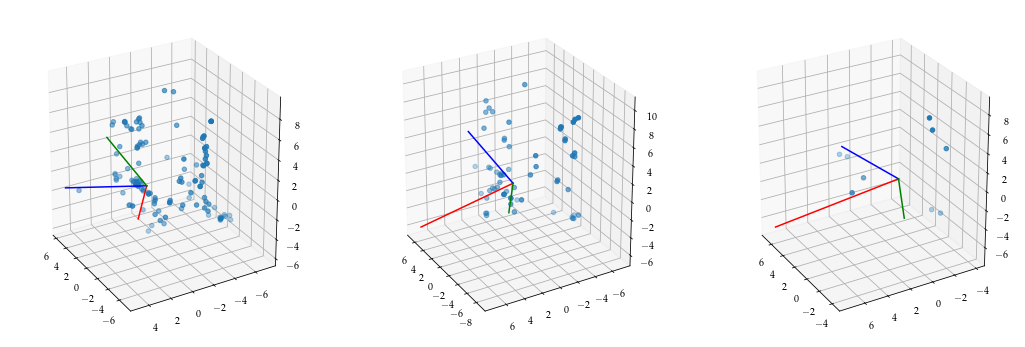

In [215]:
fig = plt.figure(figsize=(18,6))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

cols = ['r','b','g']

#for gals_test, ax in zip([gals_z2p07_sfr, gals_z3p95_sfr, gals_z5p92_sfr], [ax1,ax2]):
for gals_test, ax in zip([gals_z2p07_mstar, gals_z3p95_mstar, gals_z5p92_mstar], [ax1,ax2,ax3]):

    clusters = np.unique(gals_test[gals_test['z0_central_mcrit200'] > 1e4]['z0_centralId'])
    cluster = clusters[0]

    coods = np.array(gals_test[gals_test['z0_centralId'] == cluster][['zn_x','zn_y','zn_z']])
    coods = norm_coods(coods, L)
    axes, e_vectors = calc_axes(coods)

    p = ax.scatter(coods[:,0], coods[:,1], zs=coods[:,2])

    for j in range(len(e_vectors)):        
        e_components = e_vectors[j] * axes[j]
        ax.plot([0, e_components[0]], [0, e_components[1]], [0, e_components[2]], c=cols[j])

    ax.view_init(25, 150)

# plt.savefig('../papers/hightolowz/images/ax_3d.png', bbox_inches='tight', dpi=300)

### z = 0

In [108]:
z0_axes = []

for i, cluster in enumerate(pd.unique(gals['cen_haloId'])):
    coods = np.array(gals[gals['cen_haloId'] == cluster][['hen_x','hen_y','hen_z']])    
    coods = norm_coods(coods, L)
    ax, evec = calc_axes(coods)
    z0_axes.append(ax)
    
z0_axes = np.array(z0_axes)

In [109]:
np.sum(~np.isfinite(z0_axes[:,2]))

0

### z = n

In [57]:
def z_axes(gals):
    axes = []

    for cluster in pd.unique(gals[gals['z0_central_mcrit200'] > 1e4]['z0_centralId']):
        
        if np.sum(gals['z0_centralId'] == cluster) < 20:
            # print "Not enough galaxies..."
            axes.append([np.nan, np.nan, np.nan])
            
        else:
            coods = np.array(gals[gals['z0_centralId'] == cluster][['zn_x','zn_y','zn_z']])
            coods = norm_coods(coods, L)
            ax, evec = calc_axes(coods)
            axes.append(ax)

    return np.array(axes)

In [58]:
# eig_vals_z9p72_mstar9 = z_axes(gals_z9p72_mstar)
# eig_vals_z8p93_mstar9 = z_axes(gals_z8p93_mstar)
# eig_vals_z8p22_mstar9 = z_axes(gals_z8p22_mstar)
# eig_vals_z6p97_mstar9 = z_axes(gals_z6p97_mstar)
# eig_vals_z5p92_mstar9 = z_axes(gals_z5p92_mstar)
# eig_vals_z5p03_mstar9 = z_axes(gals_z5p03_mstar)
# eig_vals_z3p95_mstar9 = z_axes(gals_z3p95_mstar)
# eig_vals_z3p10_mstar9 = z_axes(gals_z3p10_mstar)
# eig_vals_z2p07_mstar9 = z_axes(gals_z2p07_mstar)

In [59]:
# eig_vals_z9p72_sfr = z_axes(gals_z9p72_sfr)
# eig_vals_z8p93_sfr = z_axes(gals_z8p93_sfr)
# eig_vals_z8p22_sfr = z_axes(gals_z8p22_sfr)
# eig_vals_z6p97_sfr = z_axes(gals_z6p97_sfr)

# eig_vals_z5p92_sfr = z_axes(gals_z5p92_sfr)
# eig_vals_z5p03_sfr = z_axes(gals_z5p03_sfr)
# eig_vals_z3p95_sfr = z_axes(gals_z3p95_sfr)
# eig_vals_z3p10_sfr = z_axes(gals_z3p10_sfr)
# eig_vals_z2p07_sfr = z_axes(gals_z2p07_sfr)

# eig_vals_z5p03_mstar10 = z_axes(gals_z5p03_mstar.loc[gals_z5p03_mstar['zn_stellarMass'] > 1])
# eig_vals_z3p95_mstar10 = z_axes(gals_z3p95_mstar.loc[gals_z3p95_mstar['zn_stellarMass'] > 1])
# eig_vals_z3p10_mstar10 = z_axes(gals_z3p10_mstar.loc[gals_z3p10_mstar['zn_stellarMass'] > 1])
# eig_vals_z2p07_mstar10 = z_axes(gals_z2p07_mstar.loc[gals_z2p07_mstar['zn_stellarMass'] > 1])

In [60]:
# pcl.dump([eig_vals_z9p72_mstar9,eig_vals_z8p93_mstar9,eig_vals_z8p22_mstar9,eig_vals_z6p97_mstar9,
#           eig_vals_z5p92_mstar9,eig_vals_z5p03_mstar9,eig_vals_z3p95_mstar9,eig_vals_z3p10_mstar9,
#           eig_vals_z2p07_mstar9,
#           eig_vals_z9p72_sfr,eig_vals_z8p93_sfr,eig_vals_z8p22_sfr,eig_vals_z6p97_sfr,
#           eig_vals_z5p92_sfr,eig_vals_z5p03_sfr,eig_vals_z3p95_sfr,eig_vals_z3p10_sfr,
#           eig_vals_z2p07_sfr,
#           eig_vals_z5p03_mstar10,eig_vals_z3p95_mstar10,
#           eig_vals_z3p10_mstar10,eig_vals_z2p07_mstar10], 
#           open('data/eigs_r200.p','wb'))

In [50]:
eigs = pcl.load(open('data/eigs_r200.p', 'rb'))

eig_vals_z9p72_mstar9 =eigs[0]
eig_vals_z8p93_mstar9 =eigs[1]
eig_vals_z8p22_mstar9 =eigs[2]
eig_vals_z6p97_mstar9 =eigs[3]
eig_vals_z5p92_mstar9 =eigs[4]
eig_vals_z5p03_mstar9 =eigs[5]
eig_vals_z3p95_mstar9 =eigs[6]
eig_vals_z3p10_mstar9 =eigs[7]
eig_vals_z2p07_mstar9 =eigs[8]

eig_vals_z9p72_sfr = eigs[9]
eig_vals_z8p93_sfr = eigs[10]
eig_vals_z8p22_sfr = eigs[11]
eig_vals_z6p97_sfr = eigs[12]
eig_vals_z5p92_sfr = eigs[13]
eig_vals_z5p03_sfr = eigs[14]
eig_vals_z3p95_sfr = eigs[15]
eig_vals_z3p10_sfr = eigs[16]
eig_vals_z2p07_sfr = eigs[17]

eig_vals_z5p03_mstar10 = eigs[18]
eig_vals_z3p95_mstar10 = eigs[19]
eig_vals_z3p10_mstar10 = eigs[20]
eig_vals_z2p07_mstar10 = eigs[21]

del eigs

### s & q

In [52]:
binLimits = np.linspace(0, 1, 21)
bins = np.linspace(0.025, 0.975, 20)

In [97]:

eig_vals = [[eig_vals_z2p07_sfr, eig_vals_z2p07_mstar9, eig_vals_z2p07_mstar10],
 [eig_vals_z3p10_sfr, eig_vals_z3p10_mstar9, eig_vals_z3p10_mstar10],
 [eig_vals_z3p95_sfr, eig_vals_z3p95_mstar9, eig_vals_z3p95_mstar10],
 [eig_vals_z5p03_sfr, eig_vals_z5p03_mstar9],
 [eig_vals_z5p92_sfr, eig_vals_z5p92_mstar9],
 [eig_vals_z6p97_sfr], #eig_vals_z6p97_mstar9
 [eig_vals_z8p22_sfr],
 [eig_vals_z8p93_sfr],
 [eig_vals_z9p72_sfr]]

zees = np.array([2.07,3.10,3.95,5.03,5.92,6.97,8.22,8.93,9.72])

binLimits = np.linspace(0, 1, 21)
bins = np.linspace(0.025, 0.975, 20)

ls = ['solid','dashed','dotted']

0 0 2.07
1 1 3.1
2 2 3.95
3 4 5.92
4 5 6.97
5 7 8.93


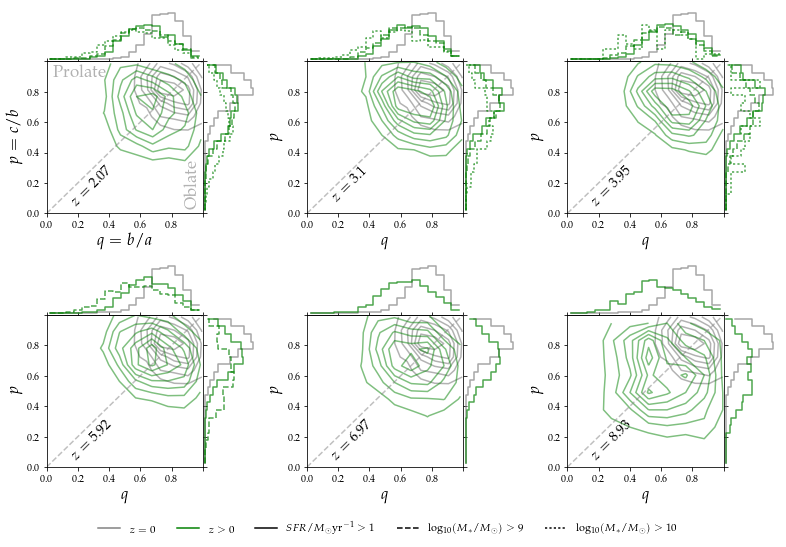

In [146]:
fig = plt.figure(figsize=(14,14))

gs = gridspec.GridSpec(15, 15)

gs.update(wspace=0, hspace=0) #, wspace=0) bottom = 0.57, top = 1,

ax1 = [fig.add_subplot(gs[1:4, 0:3]), fig.add_subplot(gs[0, 0:3]), fig.add_subplot(gs[1:4, 3])]
ax2 = [fig.add_subplot(gs[1:4, 5:8]), fig.add_subplot(gs[0, 5:8]), fig.add_subplot(gs[1:4, 8])]
ax3 = [fig.add_subplot(gs[1:4, 10:13]), fig.add_subplot(gs[0, 10:13]), fig.add_subplot(gs[1:4, 13])]

ax4 = [fig.add_subplot(gs[6:9, 0:3]), fig.add_subplot(gs[5, 0:3]), fig.add_subplot(gs[6:9, 3])]
ax5 = [fig.add_subplot(gs[6:9, 5:8]), fig.add_subplot(gs[5, 5:8]), fig.add_subplot(gs[6:9, 8])]
ax6 = [fig.add_subplot(gs[6:9, 10:13]), fig.add_subplot(gs[5, 10:13]), fig.add_subplot(gs[6:9, 13])]

idxs = [0, 1, 2, 4, 5, 7]

for i, (idx, z, ax) in enumerate(zip(idxs, zees[idxs], [ax1,ax2,ax3,ax4,ax5,ax6])):
    
    print i, idx, z
    
    # z = 0
    counts, xbins, ybins = np.histogram2d(z0_axes[:,1] / z0_axes[:,0],
                                          z0_axes[:,2] / z0_axes[:,1],
                                          bins=8)#, normed=LogNorm())

    ax[0].contour(counts.transpose(), extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], 
                colors='grey', alpha=0.6)
    
    # z = n
    eigs = eig_vals[idx][0]

    counts, xbins, ybins = np.histogram2d(
                                eigs[np.where(np.isfinite(eigs[:,0])),1][0] / \
                                eigs[np.where(np.isfinite(eigs[:,0])),0][0],
                                eigs[np.where(np.isfinite(eigs[:,0])),2][0] / \
                                eigs[np.where(np.isfinite(eigs[:,0])),1][0],
                                bins=8)#, normed=LogNorm())

    ax[0].contour(counts.transpose(), extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                alpha=0.5, label=str(z), colors='green') # colors=cmap[idx]
    
    
    phi, dummy = np.histogram(z0_axes[:,1] / z0_axes[:,0],
                                  bins=binLimits, normed=True)

    ax[1].step(bins, phi, c='grey', alpha=0.7)
    
    phi, dummy = np.histogram(z0_axes[:,2] / z0_axes[:,1],
                                  bins=binLimits, normed=True)

    ax[2].step(phi, bins, c='grey', alpha=0.7)
    
    for j, eigs in enumerate(eig_vals[idx]):
        # top marginal
        phi, dummy = np.histogram(eigs[np.where(np.isfinite(eigs[:,0])),1] / \
                                  eigs[np.where(np.isfinite(eigs[:,0])),0],
                                  bins=binLimits, normed=True)

        ax[1].step(bins, phi, c='green', linestyle=ls[j], alpha=0.7)

        # right marginal
        phi, dummy = np.histogram(eigs[np.where(np.isfinite(eigs[:,0])),2] / \
                                  eigs[np.where(np.isfinite(eigs[:,0])),1],
                                  bins=binLimits, normed=True)

        ax[2].step(phi, bins, c='green', linestyle=ls[j], alpha=0.7)

        

        
    ax[0].plot([0,1],[0,1], linestyle='dashed', c='grey', alpha=0.5)
    ax[0].set_xlim(0,1)
    ax[0].set_ylim(0,1)
    #ax.grid()
    
    ax[0].set_xlabel('$q$', size=16)
    ax[0].set_ylabel('$p$', size=16)
    
    ax[1].set_yticks([])
    ax[2].set_xticks([])
    
    ax[1].set_xticklabels([])
    ax[2].set_yticklabels([])
    
    ax[1].get_xaxis().set_tick_params(direction='in')
    ax[2].get_yaxis().set_tick_params(direction='in')
    
    ax[1].set_xlim(0,1)
    ax[2].set_ylim(0,1)
    
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['bottom'].set_visible(False)
    
    ax[0].text(0.14, .25, '$z = %s$'%z, rotation=45, size=14)#, color='grey')
    
    ax[0].set_xticklabels(['$0.0$','$0.2$','$0.4$','$0.6$','$0.8$',''])
    ax[0].set_yticklabels(['$0.0$','$0.2$','$0.4$','$0.6$','$0.8$',''])


ax1[0].text(0.88, 0.27, 'Oblate', rotation=90, size=17, alpha=0.3)
ax1[0].text(0.04, 0.9, 'Prolate', size=17, alpha=0.3)

ax1[0].set_xlabel('$q = b/a$', size=16)
ax1[0].set_ylabel('$p = c/b$', size=16)

z0Artist = plt.Line2D((0,1),(0,0), color='grey')
zNArtist = plt.Line2D((0,1),(0,0), color='green')

sfrArtist = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
mstar9Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')
mstar10Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax6[2].legend(handles=[z0Artist, zNArtist, sfrArtist, mstar9Artist, mstar10Artist],
           labels=['$z = 0$','$z > 0$','$SFR / M_{\odot} \mathrm{yr}^{-1} > 1$',
                   '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 9$',
                  '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 10$'], 
           bbox_to_anchor=(-0.7, -0.3), prop={'size':11}, frameon=False, ncol=5)


# for ax in [ax2,ax3,ax4,ax5]:
#     ax[0].set_yticklabels([])
#     ax[0].set_yticks([])
#     ax[0].set_xticklabels(['','$0.2$','$0.4$','$0.6$','$0.8$','$1.0$'])
#     ax[0].set_xlabel('$q$', size=16)
  
# plt.savefig('../papers/hightolowz/images/pq_2d.png', bbox_inches='tight', dpi=300)

0 0 2.07
T: 0.672458474332 0.196956595046
1 1 3.1
T: 0.6699127192 0.197681963625
2 2 3.95
T: 0.668641033356 0.199368074671
3 4 5.92
T: 0.670162663803 0.198696320956
4 5 6.97
T: 0.679035804676 0.199092721274
5 7 8.93
T: 0.69991998462 0.198750537914


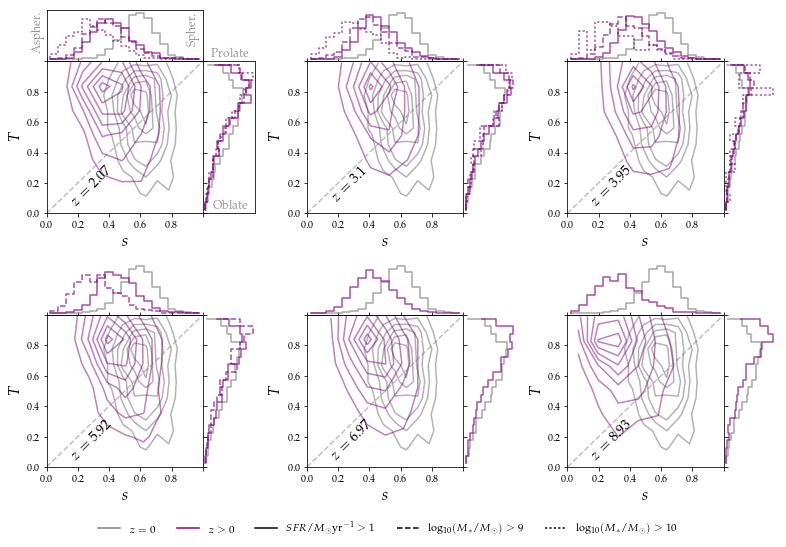

In [147]:
fig = plt.figure(figsize=(14,14))

gs = gridspec.GridSpec(15, 15)

gs.update(wspace=0, hspace=0) #, wspace=0) bottom = 0.57, top = 1,

ax1 = [fig.add_subplot(gs[1:4, 0:3]), fig.add_subplot(gs[0, 0:3]), fig.add_subplot(gs[1:4, 3])]
ax2 = [fig.add_subplot(gs[1:4, 5:8]), fig.add_subplot(gs[0, 5:8]), fig.add_subplot(gs[1:4, 8])]
ax3 = [fig.add_subplot(gs[1:4, 10:13]), fig.add_subplot(gs[0, 10:13]), fig.add_subplot(gs[1:4, 13])]

ax4 = [fig.add_subplot(gs[6:9, 0:3]), fig.add_subplot(gs[5, 0:3]), fig.add_subplot(gs[6:9, 3])]
ax5 = [fig.add_subplot(gs[6:9, 5:8]), fig.add_subplot(gs[5, 5:8]), fig.add_subplot(gs[6:9, 8])]
ax6 = [fig.add_subplot(gs[6:9, 10:13]), fig.add_subplot(gs[5, 10:13]), fig.add_subplot(gs[6:9, 13])]

idxs = [0, 1, 2, 4, 5, 7]

for i, (idx, z, ax) in enumerate(zip(idxs, zees[idxs], [ax1,ax2,ax3,ax4,ax5,ax6])):
    
    print i, idx, z
    
    # z = 0
    T = (z0_axes[:,0]**2 - z0_axes[:,1]**2) / \
        (z0_axes[:,0]**2 - z0_axes[:,2]**2)
        
#     print "T:", np.mean(T), np.std(T)
        
    counts, xbins, ybins = np.histogram2d(z0_axes[:,2] / z0_axes[:,0], T, bins=10)
    ax[0].contour(counts.transpose(), extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], 
            colors='grey', alpha=0.6)
    
    phi, dummy = np.histogram(T, bins=binLimits, normed=True)
    ax[2].step(phi, bins, c='grey', alpha=0.7)
    
    phi, dummy = np.histogram(z0_axes[:,2] / z0_axes[:,0], bins=binLimits, normed=True)
    ax[1].step(bins, phi, c='grey', alpha=0.7)
    
    # z = n   
    eigs = eig_vals[idx][0]
    
    T = (eigs[np.where(np.isfinite(eigs[:,0])),0]**2 - eigs[np.where(np.isfinite(eigs[:,0])),1]**2) / \
        (eigs[np.where(np.isfinite(eigs[:,0])),0]**2 - eigs[np.where(np.isfinite(eigs[:,0])),2]**2)
        
    print "T:", np.mean(T), np.std(T)
        
#     print np.mean(eigs[np.where(np.isfinite(eigs[:,0])),2][0] / eigs[np.where(np.isfinite(eigs[:,0])),0][0])
#     print np.std(eigs[np.where(np.isfinite(eigs[:,0])),2][0] / eigs[np.where(np.isfinite(eigs[:,0])),0][0])
        
    counts, xbins, ybins = np.histogram2d(
                                eigs[np.where(np.isfinite(eigs[:,0])),2][0] / \
                                eigs[np.where(np.isfinite(eigs[:,0])),0][0],
                                T[0], bins=7)

    ax[0].contour(counts.transpose(), extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                colors='purple', alpha=0.5, label=str(z))    
    
    for j, eigs in enumerate(eig_vals[idx]):
        
        T = (eigs[np.where(np.isfinite(eigs[:,0])),0]**2 - eigs[np.where(np.isfinite(eigs[:,0])),1]**2) / \
            (eigs[np.where(np.isfinite(eigs[:,0])),0]**2 - eigs[np.where(np.isfinite(eigs[:,0])),2]**2)

        # top marginal
        phi, dummy = np.histogram(eigs[np.where(np.isfinite(eigs[:,0])),2] / \
                                  eigs[np.where(np.isfinite(eigs[:,0])),0],
                                  bins=binLimits, normed=True)

        ax[1].step(bins, phi, c='purple', linestyle=ls[j], alpha=0.7)

        # right marginal
        phi, dummy = np.histogram(T, bins=binLimits, normed=True)

        ax[2].step(phi, bins, c='purple', linestyle=ls[j], alpha=0.7)
    
    
        
    ax[0].plot([0,1],[0,1], linestyle='dashed', c='grey', alpha=0.5)
    ax[0].set_xlim(0,1)
    ax[0].set_ylim(0,1)
    #ax.grid()
    
    ax[0].set_xlabel('$s$', size=16)
    ax[0].set_ylabel('$T$', size=16)
    
    ax[1].set_yticks([])
    ax[2].set_xticks([])
    
    ax[1].set_xticklabels([])
    ax[2].set_yticklabels([])
    
    ax[1].get_xaxis().set_tick_params(direction='in')
    ax[2].get_yaxis().set_tick_params(direction='in')
    
    ax[1].set_xlim(0,1)
    ax[2].set_ylim(0,1)
    
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['bottom'].set_visible(False)
    
    ax[0].text(0.14, .25, '$z = %s$'%z, rotation=45, size=14)#, color='grey')
    
    ax[0].set_xticklabels(['$0.0$','$0.2$','$0.4$','$0.6$','$0.8$',''])
    ax[0].set_yticklabels(['$0.0$','$0.2$','$0.4$','$0.6$','$0.8$',''])



ax1[1].spines['top'].set_visible(True)
ax1[1].spines['right'].set_visible(True)
ax1[1].spines['left'].set_visible(True)

ax1[2].spines['top'].set_visible(True)
ax1[2].spines['right'].set_visible(True)
ax1[2].spines['bottom'].set_visible(True)

ax1[2].text(0.38, 0.03, 'Oblate', size=12, alpha=0.4)
ax1[2].text(0.3, 1.03, 'Prolate', size=12, alpha=0.4)

ax1[1].text(0.9, 3, 'Spher.', rotation=90, size=12, alpha=0.4)
ax1[1].text(-0.09, 3.1, 'Aspher.', rotation=90, size=12, alpha=0.4)

# legend

z0Artist = plt.Line2D((0,1),(0,0), color='grey')
zNArtist = plt.Line2D((0,1),(0,0), color='purple')

sfrArtist = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
mstar9Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')
mstar10Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax6[2].legend(handles=[z0Artist, zNArtist, sfrArtist, mstar9Artist, mstar10Artist],
           labels=['$z = 0$','$z > 0$','$SFR / M_{\odot} \mathrm{yr}^{-1} > 1$',
                   '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 9$',
                  '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 10$'], 
           bbox_to_anchor=(-0.7, -0.3), prop={'size':11}, frameon=False, ncol=5)


# for ax in [ax1,ax2,ax3]:
#     ax[0].set_xticks([])

    
# for ax in [ax2,ax3,ax5,ax6]:
#     ax[0].set_yticks([])
    
#     ax[0].set_xticklabels(['','$0.2$','$0.4$','$0.6$','$0.8$','$1.0$'])
#     ax[0].set_xlabel('$q$', size=16)
    
# plt.savefig('../papers/hightolowz/images/sT_2d.png', bbox_inches='tight', dpi=300)

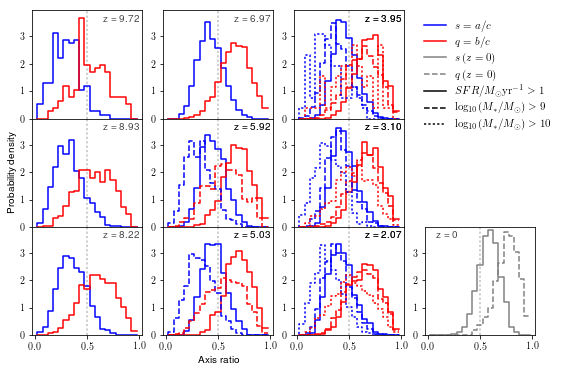

In [194]:
fig = plt.figure(figsize=(9,14))

gs = gridspec.GridSpec(4, 4)

gs.update(bottom = 0.57, top = 1, hspace=0) #, wspace=0)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[2,1])

ax7 = fig.add_subplot(gs[0,2])
ax8 = fig.add_subplot(gs[1,2])
ax9 = fig.add_subplot(gs[2,2])

ax10 = fig.add_subplot(gs[2,3])
# ax11 = fig.add_subplot(gs[1,3])

binLimits = np.linspace(0, 1, 21)
bins = np.linspace(0.025, 0.975, 20)

#linestyle='solid'

c1 = 'blue'
c2 = 'red'

means = []

for i, (ax, z) in enumerate(zip([ax9, ax8, ax7, ax6, ax5, ax4, ax3, ax2, ax1], zees)):
    
    ax.vlines(0.5, 0, 4, colors='grey', linestyle='dotted', alpha=0.5)
    
    ax.set_ylim(0, 3.95)
    
    for j, eigs in enumerate(eig_vals[i]):
        
        phi, dummy = np.histogram(eigs[np.where(np.isfinite(eigs[:,0])),2] / \
                                  eigs[np.where(np.isfinite(eigs[:,0])),0],
                                  bins=binLimits, normed=True)
        
        ax.step(bins, phi, color=c1, linestyle=ls[j])

        phi, dummy = np.histogram(eigs[np.where(np.isfinite(eigs[:,0])),2] / \
                                  eigs[np.where(np.isfinite(eigs[:,0])),1], 
                                  bins=binLimits, normed=True)
        
        ax.step(bins, phi, color=c2, linestyle=ls[j])
        
        ax.text(0.65, 0.9, "z = %.2f" % z, transform = ax.transAxes, alpha=0.7)

        if j == 0:
            means.append(np.mean(eigs[np.where(np.isfinite(eigs[:,0])),2] / eigs[np.where(np.isfinite(eigs[:,0])),0]))
        
        
ax11.plot(means, zees)
ax11.yaxis.tick_right()
ax11.yaxis.set_label_position("right")
ax11.set_xlim(0,1)
ax11.set_ylabel('$z$', rotation=0, size=15)
ax11.text(0.41, 9, 'mean($s$, SFR)')

## z0 shapes
phi, dummy = np.histogram(z0_axes[:,2] / z0_axes[:,0], bins=binLimits, normed=True)
ax10.step(bins, phi, c='grey', linestyle='solid')

phi, dummy = np.histogram(z0_axes[:,2] / z0_axes[:,1], bins=binLimits, normed=True)
ax10.step(bins, phi, c='grey', linestyle='dashed')

ax10.text(0.1, 0.9, "z = 0", transform = ax10.transAxes, alpha=0.7)
ax10.vlines(0.5, 0, 4, colors='grey', linestyle='dotted', alpha=0.5)
ax10.set_ylim(0, 3.95)
    
    
    
## Legend
sArtist = plt.Line2D((0,1),(0,0), color=c1)
qArtist = plt.Line2D((0,1),(0,0), color=c2)
Artist0s = plt.Line2D((0,1),(0,0), color='grey', linestyle='solid')
Artist0q = plt.Line2D((0,1),(0,0), color='grey', linestyle='dashed')

sfrArtist = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
mstar9Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')
mstar10Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax7.legend(handles=[sArtist, qArtist, Artist0s, Artist0q, sfrArtist, mstar9Artist, mstar10Artist],
           labels=['$s = a / c$', '$q = b / c$','$s\,(z=0)$', '$q\,(z=0)$',
                   '$SFR / M_{\odot} \mathrm{yr}^{-1} > 1$',
                   '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 9$',
                  '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 10$'], 
           bbox_to_anchor=(1.1, 1), prop={'size':11}, frameon=False)

for ax in [ax1, ax2, ax4, ax5, ax7, ax8, ax11]:
    ax.set_xticklabels([])

# for ax in [ax1,ax2,ax3,ax4,ax5, ax6, ax7, ax8, ax9]:
#     ax.set_yticklabels(['','1','2','3','4','5'])
    
ax6.set_xlabel('Axis ratio')
ax2.set_ylabel('Probability density')

# plt.savefig('../papers/hightolowz/images/ax_ratios.png', bbox_inches='tight', dpi=300)

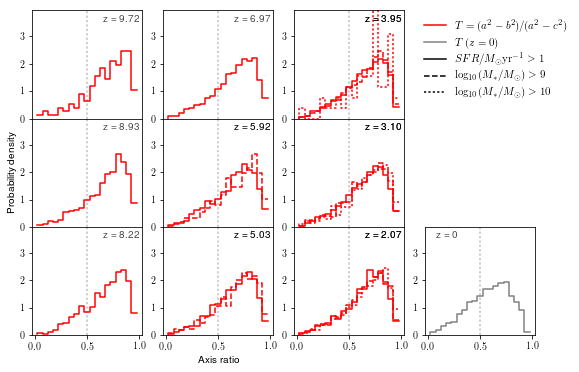

In [186]:
fig = plt.figure(figsize=(9,14))

gs = gridspec.GridSpec(4, 4)

gs.update(bottom = 0.57, top = 1, hspace=0) #, wspace=0)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[2,1])

ax7 = fig.add_subplot(gs[0,2])
ax8 = fig.add_subplot(gs[1,2])
ax9 = fig.add_subplot(gs[2,2])

ax10 = fig.add_subplot(gs[2,3])
# ax11 = fig.add_subplot(gs[1,3])

binLimits = np.linspace(0, 1, 21)
bins = np.linspace(0.025, 0.975, 20)

ls = ['solid','dashed','dotted']
#linestyle='solid'

c2 = 'blue'
c1 = 'red'

means = []

for i, (ax, z) in enumerate(zip([ax9, ax8, ax7, ax6, ax5, ax4, ax3, ax2, ax1], zees)):
    
    ax.vlines(0.5, 0, 4, colors='grey', linestyle='dotted', alpha=0.5)
    
    ax.set_ylim(0, 3.95)
    
    for j, eigs in enumerate(eig_vals[i]):
        
        T = (eigs[np.where(np.isfinite(eigs[:,0])),0]**2 - eigs[np.where(np.isfinite(eigs[:,0])),1]**2) / \
            (eigs[np.where(np.isfinite(eigs[:,0])),0]**2 - eigs[np.where(np.isfinite(eigs[:,0])),2]**2)
        
        phi, dummy = np.histogram(T, bins=binLimits, normed=True)
        
        ax.step(bins, phi, color=c1, linestyle=ls[j])

        ax.text(0.65, 0.9, "z = %.2f" % z, transform = ax.transAxes, alpha=0.7)
        
        if j == 0:
            means.append(np.mean(T))
    
    

ax11.plot(means, zees)
ax11.yaxis.tick_right()
ax11.yaxis.set_label_position("right")
ax11.set_xlim(0,1)
ax11.set_ylabel('$z$', rotation=0, size=15)
ax11.text(0.04, 9, 'mean($T$, SFR)')
    
## z0 shapes

T = (z0_axes[:,0]**2 - z0_axes[:,1]**2) / (z0_axes[:,0]**2 - z0_axes[:,2]**2)

phi, dummy = np.histogram(T, bins=binLimits, normed=True)
ax10.step(bins, phi, c='grey', linestyle='solid')

ax10.text(0.1, 0.9, "z = 0", transform = ax10.transAxes, alpha=0.7)
ax10.vlines(0.5, 0, 4, colors='grey', linestyle='dotted', alpha=0.5)
ax10.set_ylim(0, 3.95)
    
    
    
## Legend
sArtist = plt.Line2D((0,1),(0,0), color=c1)
Artist0s = plt.Line2D((0,1),(0,0), color='grey', linestyle='solid')

sfrArtist = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
mstar9Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')
mstar10Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax7.legend(handles=[sArtist, Artist0s, sfrArtist, mstar9Artist, mstar10Artist], 
           labels=['$T = (a^{2} - b^{2}) / (a^{2} - c^{2})$', '$T\,(z=0)$',
                   '$SFR / M_{\odot} \mathrm{yr}^{-1} > 1$',
                   '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 9$',
                  '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 10$'], 
           bbox_to_anchor=(1.1, 1), prop={'size':11}, frameon=False)

for ax in [ax1, ax2, ax4, ax5, ax7, ax8, ax11]:
    ax.set_xticklabels([])

# for ax in [ax1,ax2,ax3,ax4,ax5, ax6, ax7, ax8, ax9]:
#     ax.set_yticklabels(['','1','2','3','4','5'])
    
ax6.set_xlabel('Axis ratio')
ax2.set_ylabel('Probability density')

# plt.savefig('../papers/hightolowz/images/triax_param.png', bbox_inches='tight', dpi=300)

In [185]:
print np.mean(T)
print np.std(T)

0.607433043035
0.202473363216


## Mass Function

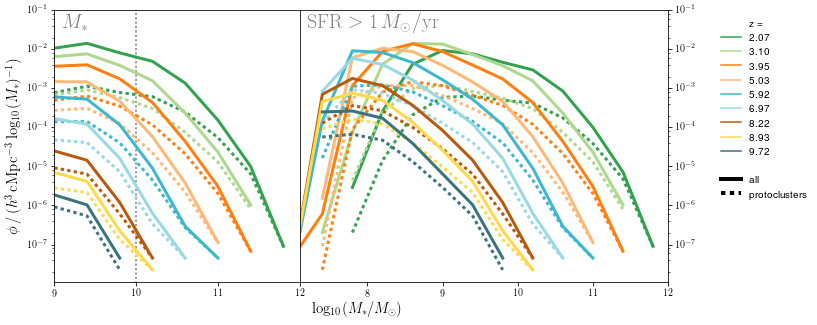

In [104]:
binLimits = np.linspace(6.8, 12.8, 16)
bins = np.linspace(7, 12.6, 15)
#print binLimits, bins

fig = plt.figure(figsize=(11,5))

gs = gridspec.GridSpec(1,10)

gs.update(wspace=0) # bottom = 0.57, top = 1, hspace=0, 

ax1 = fig.add_subplot(gs[0,0:4])
ax2 = fig.add_subplot(gs[0,4:10])

galaxy_mstar = [gals_z2p07_mstar, gals_z3p10_mstar, gals_z3p95_mstar, gals_z5p03_mstar, gals_z5p92_mstar,
                gals_z6p97_mstar, gals_z8p22_mstar, gals_z8p93_mstar, gals_z9p72_mstar]

galaxy_sfr = [gals_z2p07_sfr, gals_z3p10_sfr, gals_z3p95_sfr, gals_z5p03_sfr, gals_z5p92_sfr,
              gals_z6p97_sfr, gals_z8p22_sfr, gals_z8p93_sfr, gals_z9p72_sfr]

zees = ['2.07','3.10','3.95','5.03','5.92', '6.97','8.22','8.93','9.72']

for ax, galaxy in zip([ax1, ax2],[galaxy_mstar, galaxy_sfr]):

    for i, (gals,z) in enumerate(zip(galaxy, zees)):

        phi, dummy = np.histogram(np.log10(gals['zn_stellarMass'] * 1e10), bins=binLimits)
        phi = (phi / L**3) / (binLimits[1] - binLimits[0])

        ax.semilogy(bins, phi, c=cmap[i], label=z, linestyle='solid', linewidth=3)

        phi, dummy = np.histogram(np.log10(gals.loc[gals['z0_central_mcrit200'] > 1e4]['zn_stellarMass'] * 1e10),
                                  bins=binLimits)
        
        phi = (phi / L**3) / (binLimits[1] - binLimits[0])

        ax.semilogy(bins, phi, c=cmap[i], linestyle='dotted', linewidth=3)



ax1.text(1.05, -0.12, "$\mathrm{log_{10}}(M_* / M_{\odot})$", size=15, transform = ax1.transAxes)
ax1.set_ylabel("$\phi \,/\, (h^{3} \, \mathrm{cMpc^{-3}} \; \mathrm{log_{10}}(M_{*})^{-1})$", size=15)

ax1.set_xticks([9, 10, 11, 12])

ax1.set_xlim(9, 12)
ax2.set_xlim(7.1, 12)

ax1.set_ylim(1.1e-8, 1e-1)
ax2.set_ylim(1.1e-8, 1e-1)

ax2.yaxis.tick_right()

ax1.vlines(10, 1e-9, 1e-1, linestyle='dotted', color='grey')
ax1.vlines(9, 1e-9, 1e-1, linestyle='dotted', color='grey')

ax1.text(9.1, 3e-2, '$M_{*}$', color='grey', size=20)
ax2.text(7.2, 3e-2, '$\mathrm{SFR} > 1 \, M_{\odot} / \mathrm{yr}$', color='grey', size=20)

# ax.legend(prop={'size':10}, frameon=False)


line_z = []
for i in range(len(zees)):
    line_z.append(plt.Line2D((0,1),(0,0), color=cmap[i], linestyle='solid'))

line_all = plt.Line2D((0,1),(0,0), color='black', linestyle='solid', linewidth=4)
line_pcs = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted', linewidth=4)
line_empty = plt.Line2D((0,1),(0,0), color='white', linestyle='solid', linewidth=4)

ax2.legend(handles=[line_empty] + [line for line in line_z] + [line_empty, line_all, line_pcs], 
           labels=['z ='] + [z for z in zees] + ['','all', 'protoclusters'], 
           prop={'size':10}, frameon=False, bbox_to_anchor=(1.4, 1))

# fig.savefig('../papers/hightolowz/images/gsmf.png', dpi=300, bbox_inches='tight')

## Completeness and Purity

In [1]:
import protocluster_completeness_purity
reload(protocluster_completeness_purity)

<module 'protocluster_completeness_purity' from 'protocluster_completeness_purity.pyc'>

In [1]:
# cstats_z9p72_sfr = protocluster_completeness_purity.cluster_stats(gals_z9p72_sfr, L)
# cstats_z8p93_sfr = protocluster_completeness_purity.cluster_stats(gals_z8p93_sfr, L)
# cstats_z8p22_sfr = protocluster_completeness_purity.cluster_stats(gals_z8p22_sfr, L)
# cstats_z6p97_sfr = protocluster_completeness_purity.cluster_stats(gals_z6p97_sfr, L)

# cstats_z5p92_sfr = protocluster_completeness_purity.cluster_stats(gals_z5p92_sfr, L)
# cstats_z5p03_sfr = protocluster_completeness_purity.cluster_stats(gals_z5p03_sfr, L)
# cstats_z3p95_sfr = protocluster_completeness_purity.cluster_stats(gals_z3p95_sfr, L)
# cstats_z3p10_sfr = protocluster_completeness_purity.cluster_stats(gals_z3p10_sfr, L)
# cstats_z2p07_sfr = protocluster_completeness_purity.cluster_stats(gals_z2p07_sfr, L)

In [2]:
# cstats_z9p72_mstar9 = protocluster_completeness_purity.cluster_stats(gals_z9p72_mstar, L)
# cstats_z8p93_mstar9 = protocluster_completeness_purity.cluster_stats(gals_z8p93_mstar, L)
# cstats_z8p22_mstar9 = protocluster_completeness_purity.cluster_stats(gals_z8p22_mstar, L)
# cstats_z6p97_mstar9 = protocluster_completeness_purity.cluster_stats(gals_z6p97_mstar, L)

# cstats_z5p92_mstar9 = protocluster_completeness_purity.cluster_stats(gals_z5p92_mstar, L)
# cstats_z5p03_mstar9 = protocluster_completeness_purity.cluster_stats(gals_z5p03_mstar, L)
# cstats_z3p95_mstar9 = protocluster_completeness_purity.cluster_stats(gals_z3p95_mstar, L)
# cstats_z3p10_mstar9 = protocluster_completeness_purity.cluster_stats(gals_z3p10_mstar, L)
# cstats_z2p07_mstar9 = protocluster_completeness_purity.cluster_stats(gals_z2p07_mstar, L)

In [3]:
# cstats_z2p07_mstar10 = protocluster_completeness_purity.cluster_stats(gals_z2p07_mstar.loc[gals_z2p07_mstar['zn_stellarMass'] > 1].reset_index(drop=True), L)
# cstats_z3p10_mstar10 = protocluster_completeness_purity.cluster_stats(gals_z3p10_mstar.loc[gals_z3p10_mstar['zn_stellarMass'] > 1].reset_index(drop=True), L)
# cstats_z3p95_mstar10 = protocluster_completeness_purity.cluster_stats(gals_z3p95_mstar.loc[gals_z3p95_mstar['zn_stellarMass'] > 1].reset_index(drop=True), L)
# cstats_z5p03_mstar10 = protocluster_completeness_purity.cluster_stats(gals_z5p03_mstar.loc[gals_z5p03_mstar['zn_stellarMass'] > 1].reset_index(drop=True), L)
# cstats_z5p92_mstar10 = protocluster_completeness_purity.cluster_stats(gals_z5p92_mstar.loc[gals_z5p92_mstar['zn_stellarMass'] > 1].reset_index(drop=True), L)

In [ ]:
# pcl.dump([cstats_z9p72_sfr, cstats_z8p93_sfr, cstats_z8p22_sfr, 
#           cstats_z6p97_sfr, cstats_z5p92_sfr, cstats_z5p03_sfr, 
#           cstats_z3p95_sfr, cstats_z3p10_sfr, cstats_z2p07_sfr,
#           cstats_z9p72_mstar9, cstats_z8p93_mstar9, cstats_z8p22_mstar9, 
#           cstats_z6p97_mstar9, cstats_z5p92_mstar9, cstats_z5p03_mstar9, 
#           cstats_z3p95_mstar9, cstats_z3p10_mstar9, cstats_z2p07_mstar9, 
#           cstats_z5p92_mstar10, cstats_z5p03_mstar10, cstats_z3p95_mstar10,
#           cstats_z3p10_mstar10, cstats_z2p07_mstar10], 
#           open('data/clustering_stats_r200.p','wb'))

In [21]:
cstats = pcl.load(open('data/clustering_stats_r200.p', 'rb'))

cstats_z9p72_sfr = cstats[0]
cstats_z8p93_sfr = cstats[1]
cstats_z8p22_sfr = cstats[2]
cstats_z6p97_sfr = cstats[3]

cstats_z5p92_sfr = cstats[4]
cstats_z5p03_sfr = cstats[5]
cstats_z3p95_sfr = cstats[6]
cstats_z3p10_sfr = cstats[7]
cstats_z2p07_sfr = cstats[8]

cstats_z9p72_mstar9 = cstats[9]
cstats_z8p93_mstar9 = cstats[10]
cstats_z8p22_mstar9 = cstats[11]
cstats_z6p97_mstar9 = cstats[12]

cstats_z5p92_mstar9 = cstats[13]
cstats_z5p03_mstar9 = cstats[14]
cstats_z3p95_mstar9 = cstats[15]
cstats_z3p10_mstar9 = cstats[16]
cstats_z2p07_mstar9 = cstats[17]

cstats_z5p92_mstar10 = cstats[18]
cstats_z5p03_mstar10 = cstats[19]
cstats_z3p95_mstar10 = cstats[20]
cstats_z3p10_mstar10 = cstats[21]
cstats_z2p07_mstar10 = cstats[22]

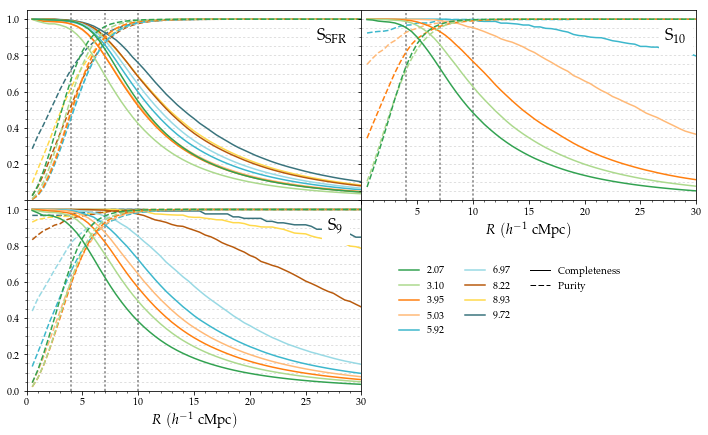

In [31]:
fig = plt.figure(figsize=(12,7))

gs = gridspec.GridSpec(2, 2)

gs.update(hspace=0, wspace=0) #bottom = 0.57, top = 1, 

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[0,1])

rangex = [float(x)/2 for x in range(61)][1:]

# redshifts = ['9.72','8.93','8.22','6.97','5.92','5.03','3.95','3.10','2.07']
redshifts = ['2.07','3.10','3.95','5.03','5.92','6.97','8.22','8.93','9.72']


cstats = [cstats_z9p72_sfr, cstats_z8p93_sfr, cstats_z8p22_sfr, 
          cstats_z6p97_sfr, cstats_z5p92_sfr, cstats_z5p03_sfr, 
          cstats_z3p95_sfr, cstats_z3p10_sfr, cstats_z2p07_sfr]


#### Plot 1
for i, cstat in enumerate(cstats):

    ax1.plot(rangex, np.mean([x[0] for x in cstat['cstats']], axis=0), c=cmap[8 - i], linestyle='dashed')

    ax1.plot(rangex, np.ma.masked_where([x[1] for x in cstat['cstats']] == 0, 
                   np.mean([x[1] for x in cstat['cstats']], axis=0)), c=cmap[8 - i])


cstats = [cstats_z9p72_mstar9, cstats_z8p93_mstar9, cstats_z8p22_mstar9, 
          cstats_z6p97_mstar9, cstats_z5p92_mstar9, cstats_z5p03_mstar9, 
          cstats_z3p95_mstar9, cstats_z3p10_mstar9, cstats_z2p07_mstar9]

    
#### Plot 2
for i, (z, cstat) in enumerate(zip(redshifts, cstats)):
    
    ax2.plot(rangex, np.mean([x[0] for x in cstat['cstats']], axis=0), c=cmap[8-i], linestyle='dashed')

    ax2.plot(rangex, np.ma.masked_where([x[1] for x in cstat['cstats']] == 0, 
                    np.vstack([x[1] for x in cstat['cstats']])).mean(axis=0), c=cmap[8-i], label=z)

    
cstats = [cstats_z5p92_mstar10, cstats_z5p03_mstar10, cstats_z3p95_mstar10, 
          cstats_z3p10_mstar10, cstats_z2p07_mstar10]

# #### Plot 3
for i, cstat in enumerate(cstats):

    ax3.plot(rangex, np.mean([x[0] for x in cstat['cstats']], axis=0), c=cmap[4-i], linestyle='dashed')

    ax3.plot(rangex, np.ma.masked_where([x[1] for x in cstat['cstats']]==0, 
                    [x[1] for x in cstat['cstats']]).mean(axis=0), cmap[4-i])

    
for ax in [ax1,ax2,ax3]:
    ## add vlines
    ax.vlines([4,7,10],0,1.05,color='grey',linestyle='dotted')
    
    ax.set_ylim(0,1.05)
    ax.set_xlim(0,30)
    
    ax.yaxis.grid(which='both', alpha=0.5, linestyle='dotted')
    ax.minorticks_on()
    

ax2.set_xlabel('$R \; (h^{-1} \; \mathrm{cMpc})$', size=14)
ax3.set_xlabel('$R \; (h^{-1} \; \mathrm{cMpc})$', size=14)

#ax3.set_ylabel('$f$', rotation=0, size=16)

ax3.set_yticklabels([])
ax1.set_xticklabels([])

ax3.set_xticklabels(['','5','10','15','20','25','30'])
ax1.set_yticklabels(['','0.2','0.4','0.6','0.8','1.0'])


line_z = []
for i in range(len(redshifts)):
    line_z.append(plt.Line2D((0,1),(0,0), color=cmap[i], linestyle='solid'))

line_space = plt.Line2D((0,1.5),(0,0), color='white', linestyle='solid', linewidth=1)
line_comp = plt.Line2D((0,1.5),(0,0), color='black', linestyle='solid', linewidth=1)
line_puri = plt.Line2D((0,1.5),(0,0), color='black', linestyle='dashed', linewidth=1)

ax3.legend(handles=[line for line in line_z] + [line_comp, line_puri, line_space, line_space], 
               labels=[z for z in redshifts] + ['Completeness', 'Purity', '', ''],
               prop={'size':10}, bbox_to_anchor=(0.8, -0.3), ncol=3, frameon=False)
    

ax1.text(26, 0.87, "S$_{\mathrm{SFR}}$", size=16, color='k', backgroundcolor='white')
ax2.text(27, 0.87, "S$_{9}$", size=16, color='k', backgroundcolor='white')
ax3.text(27.2, 0.87, "S$_{10}$", size=16, color='k', backgroundcolor='white')

# plt.savefig("../papers/protoclusters/images/compur.png", bbox_inches='tight', dpi=300)

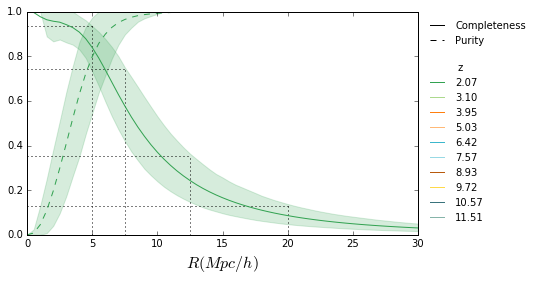

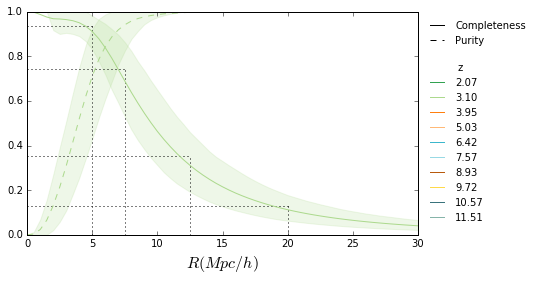

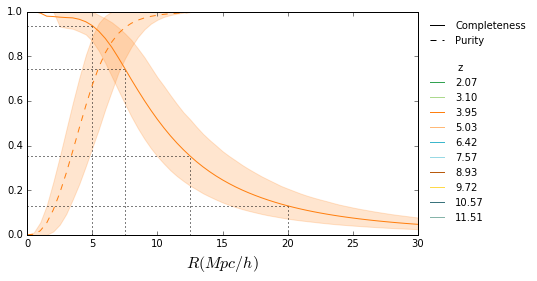

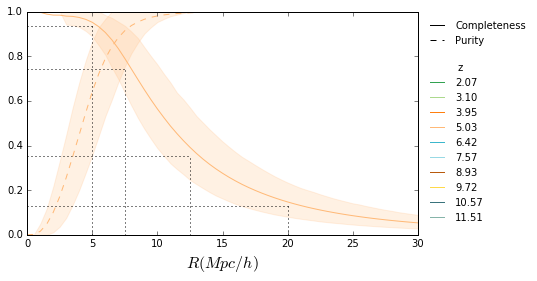

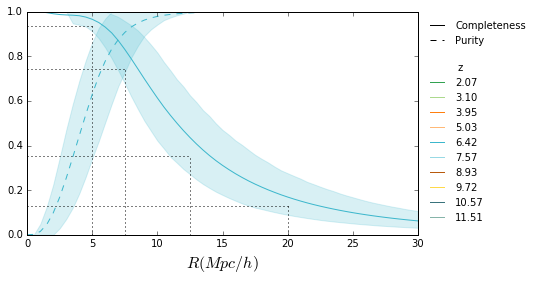

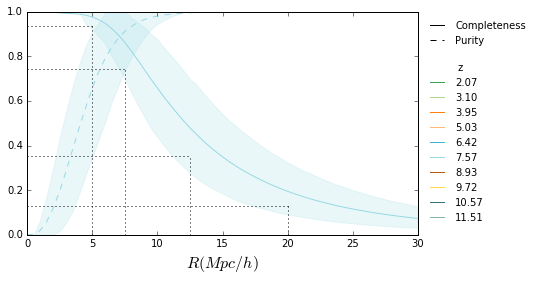

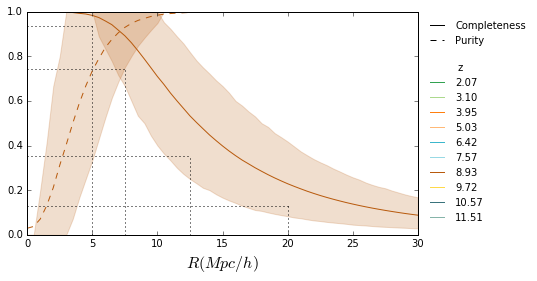

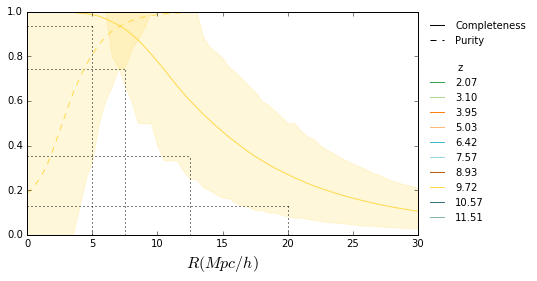

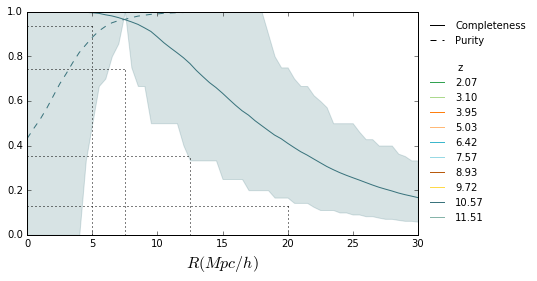

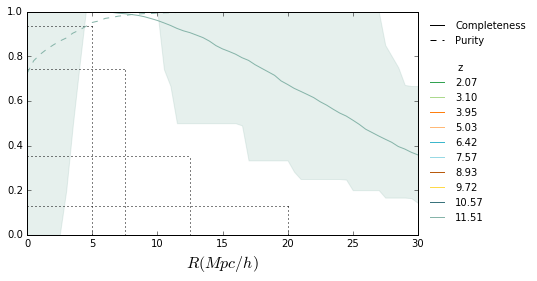

In [77]:
for j in range(10):

    fig = plt.figure(figsize=(7,4))

    rangex = [float(x)/2 for x in range(61)]

    redshifts = ['2.07','3.10','3.95','5.03','6.42','7.57','8.93', '9.72', '10.57', '11.51']

    for i, cstat in enumerate([cstats_z2p07_sfr, cstats_z3p10_sfr, cstats_z3p95_sfr, cstats_z5p03_sfr, cstats_z6p42_sfr, 
                               cstats_z7p57_sfr, cstats_z8p93_sfr, cstats_z9p72_sfr, cstats_z10p57_sfr, cstats_z11p51_sfr]):

        if i == j:

            plt.fill_between(rangex, cstat['completeness_percentiles'][:,0], 
                             cstat['completeness_percentiles'][:,1], alpha=0.2, color=cmap[i])

            plt.fill_between(rangex, cstat['purity_percentiles'][:,0], 
                             cstat['purity_percentiles'][:,1], alpha=0.2, color=cmap[i])

            plt.plot(rangex, np.mean([x[0] for x in cstat['cstats']], axis=0), c=cmap[i], linestyle='dashed')


            plt.plot(rangex,np.ma.masked_where([x[1] for x in cstat['cstats'] if x[1]] == 0, 
                           np.mean([x[1] for x in cstat['cstats'] if x[1]], axis=0)), c=cmap[i])


    plt.vlines([5,7.5,12.5,20], [0,0,0,0], np.mean([x[1] for x in cstats_z3p95_sfr['cstats']], axis=0)[[10, 15, 25, 40]], linestyle='dotted')
    plt.hlines(np.mean([x[1] for x in cstats_z3p95_sfr['cstats']], axis=0)[[10, 15, 25, 40]], [0,0,0,0], [5,7.5,12.5,20], linestyle='dotted')

    plt.xlabel('$R (Mpc / h)$', size=16)

    line_z = []
    for i in range(len(redshifts)):
        line_z.append(plt.Line2D((0,1),(0,0), color=cmap[i], linestyle='solid'))

    line_comp = plt.Line2D((0,1.5),(0,0), color='black', linestyle='solid', linewidth=1)
    line_puri = plt.Line2D((0,1.5),(0,0), color='black', linestyle='dashed', linewidth=1)

    line_space = plt.Line2D((0,1.5),(0,0), color='white', linestyle='solid', linewidth=1)

    plt.legend(handles=[line_comp, line_puri, line_space] + [line for line in line_z], 
               labels=['Completeness', 'Purity', '\n z'] + [z for z in redshifts],
               prop={'size':10}, frameon=False, bbox_to_anchor=(1.3, 1))

    plt.savefig("../papers/hightolowz/images/compur_single_%s.png" % j, bbox_inches='tight', dpi=300)

## Angular size

In [187]:
from astropy.cosmology import Planck13 as cosmo
from astropy import units as u

In [189]:
z = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [195]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

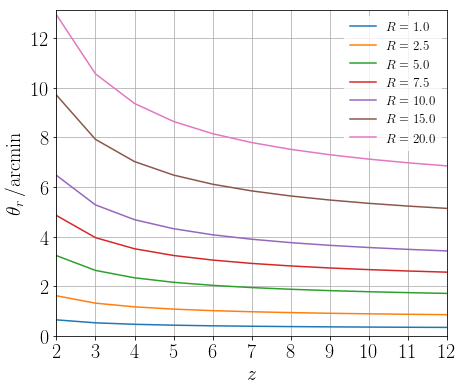

In [221]:
plt.figure(figsize=(7,6))

max_arcsecs = 0
for d in [1,2.5,5,7.5,10, 15, 20]:
    arcsecs = (cosmo.arcsec_per_kpc_comoving(z) * (d * u.Mpc)).to(u.arcmin)
    plt.plot(z, arcsecs, label='$R=%.1f$'%d)
    max_arcsecs = max(max_arcsecs, max(arcsecs))

    
plt.ylim(0, max_arcsecs.value + 0.2)
plt.xlim(2, 12)

plt.grid()

plt.ylabel(r'$\theta_{r} \, / \mathrm{arcmin}$', size=20)
plt.xlabel(r'$z$', size=20)

plt.tick_params(labelsize=20)
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

legend = plt.legend(prop={'size':13})
legend.get_frame().set_edgecolor('white')

# plt.savefig("../papers/hightolowz/images/angular_size.png", bbox_inches='tight', dpi=300)